# Novelty
In this notebook, we will focus on the novelty aspect of the generated ligands. We will compare our compounds with two sets of compounds:
1. ChEMBL 33 compounds
2. Crystal Structure First Compounds

In [18]:
# imports
import pandas as pd
from rdkit.Chem import (AllChem, PandasTools)
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import HTML
from src.evaluation.utils import get_chembl_compounds_from_id, save_chemb_mcs_to_file
from pathlib import Path
PandasTools.RenderImagesInAllDataFrames(images=True)

## 1. ChEMBL 33 comparision
Since ChEMBL 33 comprises XXX componds, we perform the similarity comparision between our generated compounds and the ChEMBL compounds in a seperate script. To this end, the following steps need to be performed:
1. Download `chembl_33.sdf.gz` from [ChEMBL](https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_33/) and unpack it.
2. Run the ChEBML comparision script, e.g., with 
```bash
python3 src/evaluation/chembl/chembl_database_comp.py -p -o results_5n1f_25_02/5n1f/results_chembl.csv -c evaluation/chembl_33.sdf -l results_5n1f_25_02/5n1f/results.sdf
```
With that, we determine the most similar ChEMBL compound of each generated PKA ligand with a estimated binding affinity $\leq 1,000$ nM (`-p`).

**Note:** This script requires up to XXX GB RAM and takes about XXX min. The comparision results for the hamster PKA PDB `5n1f` are thus already available at `results_5n1f_25_02/5n1f/results_chembl.csv`. 

First, we load and prepare the precomputed comparision results:

,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP,FP,GA,AP_smiles,FP_smiles,GA_smiles,most_similar_chembl_ligand.chembl_id,most_similar_chembl_ligand.similarity
0,,0.825466,133.57,2,"InChI=1S/C24H29N5/c1-23(2,3)19-6-4-17(5-7-19)1...",136,8,NaN,[4*]c1ccnc2[nH]cc(C#N)c12,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,CHEMBL603262,0.85
1,,1.738471,67.60,2,InChI=1S/C23H25ClN4/c1-2-26-22-27-14-11-21(28-...,420,7,NaN,[16*]c1ccnc(N[C@H]([56*])C)n1,Clc1ccc(C2(c3ccccc3)CC[NH2+]CC2)cc1,NaN,CHEMBL228133,0.72
2,,2.240375,29.01,2,InChI=1S/C23H20Cl2N4/c24-18-7-5-17(6-8-18)23(9...,8,7,NaN,[17*]c1ncnc2[nH]cc(Cl)c12,Clc1ccc(C2(c3ccccc3)CC[NH2+]CC2)cc1,NaN,CHEMBL228133,0.71
3,,2.925760,124.80,2,InChI=1S/C18H19N5O2/c1-19-16-10-15-13(11-21-16...,327,348,NaN,[22*]n1c(=O)c([41*])cc2cnc(NC)cc21,CCC(=O)NCc1ccccn1,NaN,CHEMBL3883473,0.49
4,,3.619756,41.54,2,"InChI=1S/C21H29ClN4/c1-20(2,3)16-6-4-15(5-7-16...",220,8,NaN,[4*]Nc1cc([16*])c(Cl)cn1,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,CHEMBL603262,0.63

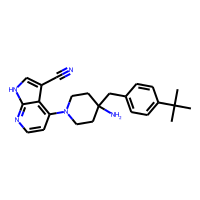
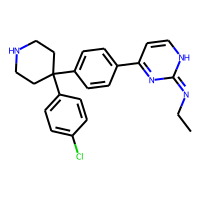
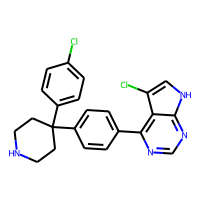
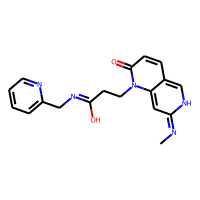
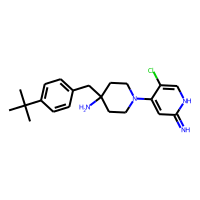

In [33]:
# read results
data_chembl = pd.read_csv("../results_5n1f_25_02/5n1f/results_chembl.csv", index_col=0).dropna(axis=1, how='all')
# generate mols from inchi
data_chembl['ROMol'] = data_chembl['inchi'].map(AllChem.MolFromInchi)
HTML(data_chembl.head().to_html(notebook=True))

Each compound is annotated with the ChEMBL ID of it's most similar ChEMBL compound (`most_similar_chembl_ligand.compound_id`) and the Tanimoto similarity to that ligand (`most_similar_chembl_ligand.similarity`).

We will first focus on the similairty values, and after, we will inspect some of these ChEMBL compounds themself.

### Similarity statistics and quantities
Let,s first look at the distibution of Tanimoto similarity values between the ligands and their respective most similar ChEMBL ligand.

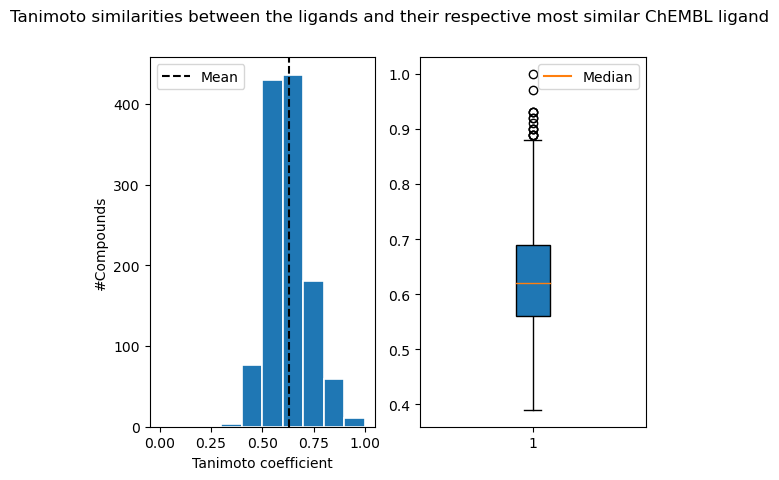

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2)

# Histogram of similarities
ax1.hist(
    data_chembl['most_similar_chembl_ligand.similarity'],
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', 
    linewidth=1.2
)
ax1.set_xlabel('Tanimoto coefficient')
ax1.set_ylabel('#Compounds')
mean_line = ax1.axvline(data_chembl['most_similar_chembl_ligand.similarity'].mean(), color='k', linestyle='dashed', label="Mean")
ax1.legend(handles=[mean_line])

# Boxplot of similarities
boxplot = ax2.boxplot(data_chembl['most_similar_chembl_ligand.similarity'], patch_artist=True)
median_line = boxplot['medians'][0]
median_legend_handle, = ax2.plot([], [], color=median_line.get_color(), label="Median")
ax2.legend(handles=[median_legend_handle])

plt.suptitle("Tanimoto similarities between the ligands and their respective most similar ChEMBL ligand")
plt.show()

In [21]:
data_chembl['most_similar_chembl_ligand.similarity'].describe()

count    1196.000000
mean        0.630351
std         0.097345
min         0.390000
25%         0.560000
50%         0.620000
75%         0.690000
max         1.000000
Name: most_similar_chembl_ligand.similarity, dtype: float64

In [22]:
thresholds = [1, 0.95, 0.9, 0.85, 0.8]
print(f"Number of ligands with similarity of >= threshold to at least one ChEMBL compound:")
print(f"# Compounds\t| Threshold")
print(f"-----------\t|----------")
for threshold in thresholds:
    print(f"{threshold}\t\t| {sum(data_chembl['most_similar_chembl_ligand.similarity'] >= threshold)}")


Number of ligands with similarity of >= threshold to at least one ChEMBL compound:
# Compounds	| Threshold
-----------	|----------
1		| 1
0.95		| 2
0.9		| 11
0.85		| 29
0.8		| 70


We will now only consider the most similar ChEMBL compounds with a similarity of $\geq 0.9$ to the respective PKA compound:

,index,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP,SE,FP,GA,B1,B2,AP_smiles,SE_smiles,FP_smiles,GA_smiles,B1_smiles,B2_smiles,most_similar_chembl_ligand.chembl_id,most_similar_chembl_ligand.similarity
0,52,,40.212366,7.57,2,"InChI=1S/C22H29N5/c1-21(2,3)17-6-4-16(5-7-17)1...",11,NaN,8,NaN,NaN,NaN,[18*]c1ncnc2[nH]ccc12,NaN,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,NaN,NaN,CHEMBL597211,1.00
1,107,,75.006211,8.46,2,"InChI=1S/C21H28N6/c1-20(2,3)16-6-4-15(5-7-16)1...",71,NaN,8,NaN,NaN,NaN,[14*]c1ncnc2[nH]cnc12,NaN,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,NaN,NaN,CHEMBL2420908,0.97
2,208,,151.416659,9.42,2,InChI=1S/C20H16O2/c1-14-13-18(11-12-19(14)21)1...,236,NaN,336,NaN,NaN,NaN,[3*]c1ccc(O)c(C)c1,NaN,O=C(c1ccccc1)c1ccccc1,NaN,NaN,NaN,CHEMBL1928176,0.93
3,929,,770.662310,-8.77,2,InChI=1S/C17H12N4/c18-7-2-4-12-3-1-5-13(9-12)1...,136,NaN,161,NaN,NaN,NaN,[4*]c1ccnc2[nH]cc(C#N)c12,NaN,N#CCCc1ccccc1,NaN,NaN,NaN,CHEMBL3959637,0.93
4,999,,844.463227,-3.24,2,"InChI=1S/C13H12N4O2S/c1-14-20(18,19)10-4-2-9(3...",11,NaN,291,NaN,NaN,NaN,[18*]c1ncnc2[nH]ccc12,NaN,CNS(=O)(=O)c1ccccc1,NaN,NaN,NaN,CHEMBL4068933,0.93
5,127,,88.117491,150.37,2,InChI=1S/C24H32N4/c1-17-15-20-21(9-12-26-22(20...,299,NaN,8,NaN,NaN,NaN,[12*]c1ccnc2[nH]c(C)cc12,NaN,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,NaN,NaN,CHEMBL603262,0.92
6,482,,361.060900,-2.09,2,InChI=1S/C19H22FNO2/c1-13-10-17(6-7-19(13)22)2...,236,NaN,44,NaN,NaN,NaN,[3*]c1ccc(O)c(C)c1,NaN,OC[C@@H]1C[NH2+]CC[C@H]1c1ccc(F)cc1,NaN,NaN,NaN,CHEMBL254489,0.92
7,680,,548.652857,65.62,2,InChI=1S/C13H12N4O2/c1-18-8-3-4-10(19-2)9(5-8)...,71,NaN,442,NaN,NaN,NaN,[14*]c1ncnc2[nH]cnc12,NaN,COc1ccc(OC)cc1,NaN,NaN,NaN,CHEMBL4974501,0.91
8,250,,180.750997,-19.87,2,InChI=1S/C20H18N4O2S/c25-19-14-4-3-13(9-12(14)...,334,NaN,406,NaN,NaN,NaN,[15*]c1ccc2c(=O)[nH]ccc2c1,NaN,O=c1[nH]c(C[NH+]2CCCC2)nc2ccsc12,NaN,NaN,NaN,CHEMBL4080367,0.90
9,657,,526.496902,21.34,2,InChI=1S/C18H15N3O/c22-18-14-11-20-21-17(14)13...,69,NaN,118,NaN,NaN,NaN,[22*]c1cccc2c1C(=O)c1c-2n[nH]c1[40*],NaN,NCCc1ccccc1,NaN,NaN,NaN,CHEMBL359180,0.90

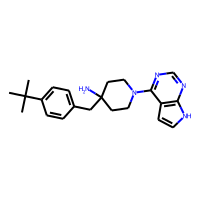
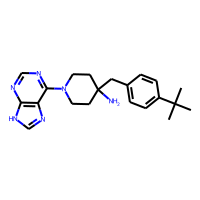
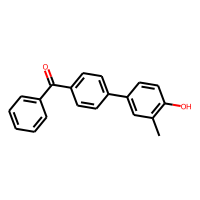
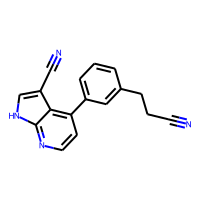
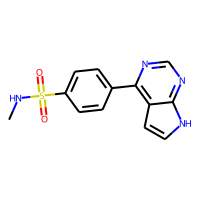
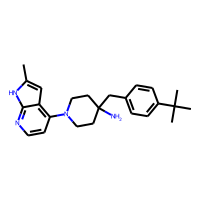
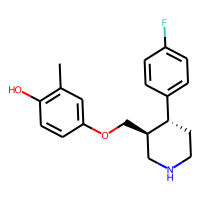
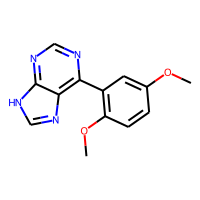
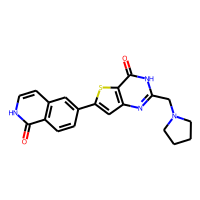
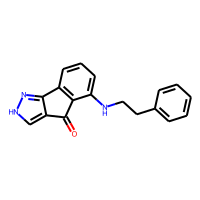
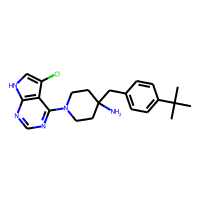

In [32]:
most_similar_pka_compounds = (data_chembl[data_chembl['most_similar_chembl_ligand.similarity'] >= 0.9]
                              .sort_values('most_similar_chembl_ligand.similarity', ascending=False)
                              .reset_index())
HTML(most_similar_pka_compounds.to_html(notebook=True))

To inspect these ChEMBL compounds, we first need to get these compounds using their ID

  0%|          | 0/10 [00:00<?, ?it/s]

,chembl_id,ROMol,inchi
0,CHEMBL359180,,InChI=1S/C20H17N3O2/c1-3-12-7-9-13(10-8-12)18-...
1,CHEMBL254489,,InChI=1S/C18H20FNO/c19-16-8-6-14(7-9-16)18-10-...
2,CHEMBL597211,,"InChI=1S/C22H29N5/c1-21(2,3)17-6-4-16(5-7-17)1..."
3,CHEMBL603262,,"InChI=1S/C23H30N4/c1-22(2,3)18-6-4-17(5-7-18)1..."
4,CHEMBL1928176,,InChI=1S/C20H16O3/c1-13-11-16(9-10-19(13)22)14...
5,CHEMBL2420908,,InChI=1S/C17H20N6/c18-17(10-13-4-2-1-3-5-13)6-...
6,CHEMBL3959637,,InChI=1S/C16H13N3/c1-2-11-4-3-5-12(8-11)14-6-7...
7,CHEMBL4068933,,"InChI=1S/C12H10N4O2S/c13-19(17,18)9-3-1-8(2-4-..."
8,CHEMBL4080367,,InChI=1S/C16H16N4OS/c21-16-15-12(9-13(22-15)11...
9,CHEMBL4974501,,InChI=1S/C14H14N4O3/c1-19-9-5-4-8(12(20-2)13(9...

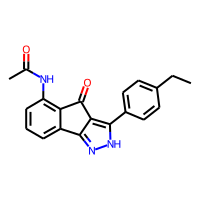
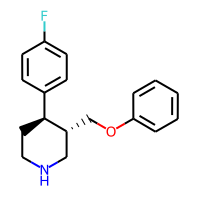
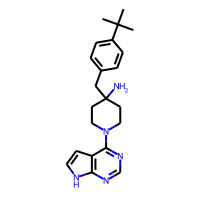
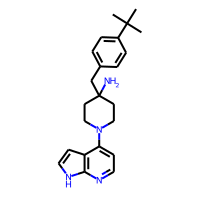
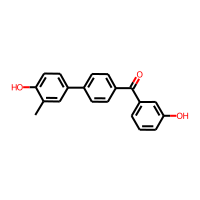
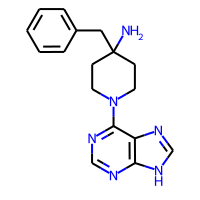
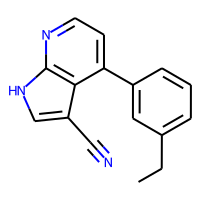
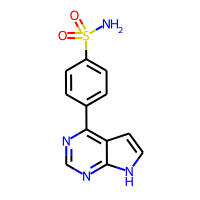
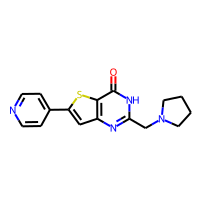
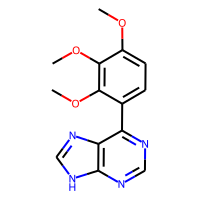

In [24]:
# get these compounds
most_similar_chembl_compounds = get_chembl_compounds_from_id(list(most_similar_pka_compounds['most_similar_chembl_ligand.chembl_id'].unique()))
HTML(most_similar_chembl_compounds.to_html(notebook=True))

We determine the MCS between a ChEMBL compounds (leftmost ligand) and the respective similar generated compounds and save it to PNG files within `results_5n1f_25_02/5n1f/chembl_mcs`.

In [25]:
save_chemb_mcs_to_file(most_similar_chembl_compounds, most_similar_pka_compounds, Path("../results_5n1f_25_02/5n1f/chembl_mcs"))